In [13]:
import pandas as pd
import numpy as np
import pathlib
import os
import shutil

from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
    mean_pinball_loss,
)

from utils_experiment import (
    load_data,
    get_model_list,
    plot_forecasts_analysis,
    rmse,
    pinball_loss,
    average_pinball_loss,
    plot_quantile_forecast
)

# General data loading for all experiments 

In [14]:
exp_test_description = "Full_Report"
directory = f"/h/kupfersk/cfpr_2025/generate_forecasts/output/"

report_sim_dates = open("experiment_cutoff_dates.txt", 'r').read().split()
# report_sim_dates = report_sim_dates[:-1]

# report_sim_dates= [report_sim_dates[-1]]

target_categories = [
    'Bakery and cereal products (excluding baby food)',
     'Dairy products and eggs',
     'Fish, seafood and other marine products',
     'Food purchased from restaurants',
     'Food',
     'Fruit, fruit preparations and nuts',
     'Meat',
     'Other food products and non-alcoholic beverages',
     'Vegetables and vegetable preparations'
]


target_categories = [f"food_cpi: {col}" for col in target_categories]

start_years = [1986]
random_seed = 42

print("Target Categories:\n" + '\n'.join(target_categories))
print("Report Simulation Dates:\n" + '\n'.join(report_sim_dates))



file_path = "../data/processed_data/all_data_processed.csv"
all_data, foodprice_df, target_categories, all_covariates = load_data(target_categories, file_path)

Target Categories:
food_cpi: Bakery and cereal products (excluding baby food)
food_cpi: Dairy products and eggs
food_cpi: Fish, seafood and other marine products
food_cpi: Food purchased from restaurants
food_cpi: Food
food_cpi: Fruit, fruit preparations and nuts
food_cpi: Meat
food_cpi: Other food products and non-alcoholic beverages
food_cpi: Vegetables and vegetable preparations
Report Simulation Dates:
2018-07-01
2019-07-01
2020-07-01
2021-07-01
2022-07-01
2023-07-01


In [15]:
EXP_BASE_LIST = ["ag_local", "ag_global_cpi", "ag_global_with_covariates"]

ignore_list = [".csv",
               "ipynb",
                "llama",
#                 "gemini",
#                 "claude",
#                 "gpt",
               "GPT_P",
#                "human",
               "_R",
               "Mixtral",
               '5th',
               "restaurants",
               "DeepARModel_exp",
               "ChronosModel_exp",
               "PatchTSTModel_exp",
               "DLinearModel_exp",
               "exp7",
               "exp8",
               "corr",
               "economic",
#                "report",

               

               
               
]

experiments = []
# for experiment_name in os.listdir(f"{directory}{exp_test_description}"):
#     if 'ipynb' not in experiment_name:
#         if '.csv' not in experiment_name:
#             if "ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp" not in experiment_name:
#                 if "llama" not in experiment_name:
#                     if "gemini" not in experiment_name:
#                         if "claude" not in experiment_name:
#                             if "gpt" not in experiment_name:



#                 experiments.append(experiment_name)

for experiment_name in os.listdir(f"{directory}{exp_test_description}"):
    if all(keyword not in experiment_name for keyword in ignore_list):
        experiments.append(experiment_name)


        # # Read the file and store the content in a list
        # llm_directory = '/h/kupfersk/cfpr_llm/Results_percentiles/Raw_data/'

        # with open((llm_directory + 'llm_models.txt'), 'r') as file:
        #     # Read all lines and strip any extra whitespace/newline characters
        #     loaded_list = [line.strip() for line in file]


        # experiments = experiments + loaded_list
experiments

['ag_local_DeepARModel',
 'ag_global_all_TemporalFusionTransformerModel_exp1_human_',
 'ag_global_cpi_with_covariates_TemporalFusionTransformerModel',
 'gemini-1.5-pro_report_True_with_future_forecasts_True',
 'ag_global_all_SimpleFeedForwardModel_exp1_human_',
 'ag_global_all_SimpleFeedForwardModel_exp5_geopolitical_',
 'ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp1_llm_',
 'ag_local_AutoETSModel',
 'gemini-1.5-pro_report_False_with_future_forecasts_True',
 'ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_climate_',
 'ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp1_human_',
 'claude-3-5-sonnet-20240620_report_True_with_future_forecasts_True',
 'ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_geopolitical_',
 'ag_global_all_PatchTSTModel',
 'ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_manufacturing_',
 'gemini-1.5-pro_report_True',
 'gpt-4o_report_True',
 'ag_global_all_TemporalFusionTransfo

### Ensure all necessary data is stored in Experimental_Analysis folder for easy access 

### Define evaluation metrics and calculate mape for all periods

In [16]:
point_metrics = {
    "r2_score": r2_score,
    "mae": mean_absolute_error,
    "mape": mean_absolute_percentage_error,
    "mse": mean_squared_error,
    "rmse": rmse,
}

In [17]:
experiments

['ag_local_DeepARModel',
 'ag_global_all_TemporalFusionTransformerModel_exp1_human_',
 'ag_global_cpi_with_covariates_TemporalFusionTransformerModel',
 'gemini-1.5-pro_report_True_with_future_forecasts_True',
 'ag_global_all_SimpleFeedForwardModel_exp1_human_',
 'ag_global_all_SimpleFeedForwardModel_exp5_geopolitical_',
 'ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp1_llm_',
 'ag_local_AutoETSModel',
 'gemini-1.5-pro_report_False_with_future_forecasts_True',
 'ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_climate_',
 'ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp1_human_',
 'claude-3-5-sonnet-20240620_report_True_with_future_forecasts_True',
 'ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_geopolitical_',
 'ag_global_all_PatchTSTModel',
 'ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_manufacturing_',
 'gemini-1.5-pro_report_True',
 'gpt-4o_report_True',
 'ag_global_all_TemporalFusionTransfo

In [18]:
import json


def compute_all_scores(report_sim_dates, study_metric="mape"):
    global forecast_df
    global actual_df
    global predicted_categories
    
    results = []
    
        
    # Load the dictionary from the JSON file
    with open('../generate_forecasts/target_category_dict_filt.json', 'r') as json_file:
        target_category_dict = json.load(json_file)
        
    for start_year in start_years:



        for EXPERIMENT_NAME in experiments:
            predicted_categories = []
            
            print(EXPERIMENT_NAME)
            if 'ag' in EXPERIMENT_NAME :
                predicted_categories = target_categories
#                 if "R" not in EXPERIMENT_NAME:
#                     if 'exp' in EXPERIMENT_NAME: 
#                         general_experiment = f"exp{EXPERIMENT_NAME.split('_exp')[-1]}"
                        
#                         predicted_categories_in = target_category_dict[general_experiment]
                    
                    # Drop items containing the word 'restaurant' or exactly 'food_cpi: Food'
#                     predicted_categories = [item for item in predicted_categories_in if 'restaurant' not in item.lower() and item != 'food_cpi: Food']
#                 else:
#                     predicted_categories = target_categories
                
            else:
                predicted_categories = [
                                        'food_cpi: Bakery and cereal products (excluding baby food)',
                                         'food_cpi: Meat',
                                         'food_cpi: Vegetables and vegetable preparations'
                                    ]

            for category in predicted_categories:
                if "restaurant" in category:
                    continue 
                    
                scores = []

                for cutoff_date in report_sim_dates:

                    forecast_csv_path = f"../generate_forecasts/output/{exp_test_description}/{EXPERIMENT_NAME}/random_seed_{random_seed}/{cutoff_date}/forecasts/{category}.csv"
                    forecast_df = pd.read_csv(forecast_csv_path, index_col=0)
                    forecast_df.index = pd.to_datetime(forecast_df.index)

                    actual_df = foodprice_df[category].loc[
                        [
                            date
                            for date in forecast_df.index
                            if date in foodprice_df.index
                        ]
                    ]
                    
                    if report_sim_dates[-1] == cutoff_date:
                        forecast_df = forecast_df.iloc[:-1]
                        actual_df = actual_df.iloc[:-1]


                    if study_metric in point_metrics:
                        median_col = "q_0.5"
                        y_pred = forecast_df[median_col]
                        y_true = actual_df
                        if len(y_pred) > len(y_true):
                            y_pred = y_pred[: len(y_true)]
                        scores.append(
                            point_metrics[study_metric](y_true=y_true, y_pred=y_pred)
                        )

                    elif study_metric == "pinball_loss":
                        y_pred = forecast_df
                        y_true = actual_df
                        if len(y_pred) > len(y_true):
                            y_pred = y_pred[: len(y_true)]
                        scores.append(
                            average_pinball_loss(
                                y_true=y_true,
                                y_pred_quantiles=y_pred,
                                quantiles=[
                                    0.01,
                                    0.05,
                                    0.1,
                                    0.25,
                                    0.75,
                                    0.9,
                                    0.95,
                                    0.99,
                                ],
                            )
                        )

                mean_score = np.mean(scores)
                std_score = np.std(scores)

                results.append(
                    {   "year": start_year,
                        "experiment": EXPERIMENT_NAME,
                        "category": category,
                        "mean_score": mean_score,
                        "std_score": std_score,
                        "scores": scores
                    }
                )

    return pd.DataFrame(results)



In [19]:
with open('../generate_forecasts/target_category_dict_filt.json', 'r') as json_file:
    target_category_dict = json.load(json_file)
    
target_category_dict

{'exp5_geopolitical_': ['food_cpi: Bakery and cereal products (excluding baby food)',
  'food_cpi: Dairy products and eggs',
  'food_cpi: Fish, seafood and other marine products',
  'food_cpi: Food purchased from restaurants',
  'food_cpi: Food',
  'food_cpi: Fruit, fruit preparations and nuts',
  'food_cpi: Meat',
  'food_cpi: Other food products and non-alcoholic beverages',
  'food_cpi: Vegetables and vegetable preparations'],
 'exp5_manufacturing_': ['food_cpi: Bakery and cereal products (excluding baby food)',
  'food_cpi: Dairy products and eggs',
  'food_cpi: Fish, seafood and other marine products',
  'food_cpi: Food purchased from restaurants',
  'food_cpi: Food',
  'food_cpi: Fruit, fruit preparations and nuts',
  'food_cpi: Meat',
  'food_cpi: Other food products and non-alcoholic beverages',
  'food_cpi: Vegetables and vegetable preparations'],
 'exp5_climate_': ['food_cpi: Bakery and cereal products (excluding baby food)',
  'food_cpi: Dairy products and eggs',
  'food_cpi

In [20]:
## For classical model experiments 

mape_df = compute_all_scores(report_sim_dates, "mape")
mape_df

mape_df['path']= "f'./output/{exp_test_description}/{EXPERIMENT_NAME}/random_seed_42/{cutoff_date}/forecasts/{category}.csv'"

mape_df

ag_local_DeepARModel
ag_global_all_TemporalFusionTransformerModel_exp1_human_
ag_global_cpi_with_covariates_TemporalFusionTransformerModel
gemini-1.5-pro_report_True_with_future_forecasts_True
ag_global_all_SimpleFeedForwardModel_exp1_human_
ag_global_all_SimpleFeedForwardModel_exp5_geopolitical_
ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp1_llm_
ag_local_AutoETSModel
gemini-1.5-pro_report_False_with_future_forecasts_True
ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_climate_
ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp1_human_
claude-3-5-sonnet-20240620_report_True_with_future_forecasts_True
ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_geopolitical_
ag_global_all_PatchTSTModel
ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_manufacturing_
gemini-1.5-pro_report_True
gpt-4o_report_True
ag_global_all_TemporalFusionTransformerModel
ag_local_SimpleFeedForwardModel
gemini-1.5-pro_report_False


,year,experiment,category,mean_score,std_score,scores,path
0,1986,ag_local_DeepARModel,food_cpi: Bakery and cereal products (excludin...,0.036713,0.021999,"[0.011036732060852398, 0.019971501010228897, 0...",f'./output/{exp_test_description}/{EXPERIMENT_...
1,1986,ag_local_DeepARModel,food_cpi: Dairy products and eggs,0.032611,0.016330,"[0.019867074994984066, 0.027847746093486305, 0...",f'./output/{exp_test_description}/{EXPERIMENT_...
2,1986,ag_local_DeepARModel,"food_cpi: Fish, seafood and other marine products",0.022050,0.015371,"[0.010854690989193488, 0.011447317441345844, 0...",f'./output/{exp_test_description}/{EXPERIMENT_...
3,1986,ag_local_DeepARModel,food_cpi: Food,0.033385,0.021728,"[0.01192819864460277, 0.015630026544120393, 0....",f'./output/{exp_test_description}/{EXPERIMENT_...
4,1986,ag_local_DeepARModel,"food_cpi: Fruit, fruit preparations and nuts",0.038141,0.017945,"[0.02813726903135804, 0.02401235303421688, 0.0...",f'./output/{exp_test_description}/{EXPERIMENT_...
...,...,...,...,...,...,...,...
279,1986,ag_local_TemporalFusionTransformerModel,food_cpi: Food,0.032911,0.020694,"[0.013975713709548246, 0.01231863941864048, 0....",f'./output/{exp_test_description}/{EXPERIMENT_...
280,1986,ag_local_TemporalFusionTransformerModel,"food_cpi: Fruit, fruit preparations and nuts",0.046375,0.022073,"[0.02169973008505353, 0.03503221154346888, 0.0...",f'./output/{exp_test_description}/{EXPERIMENT_...
281,1986,ag_local_TemporalFusionTransformerModel,food_cpi: Meat,0.031168,0.010951,"[0.016441312292381497, 0.04095060925211494, 0....",f'./output/{exp_test_description}/{EXPERIMENT_...
282,1986,ag_local_TemporalFusionTransformerModel,food_cpi: Other food products and non-alcoholi...,0.031610,0.021170,"[0.012615555976243205, 0.011859104984157813, 0...",f'./output/{exp_test_description}/{EXPERIMENT_...


# Figure 1. Sensitivity analysis by regressor theme sorted by food category

Steps:
1) load in all data
2) Do this for TemporalFusionTransformer
3) Repeat for global all and global+covariates 


In [21]:
# Define the function to assign condition based on keywords in experiment names
def assign_condition(experiment):
    experiment = experiment.lower()  # Make lowercase for case-insensitive matching
    if 'climate' in experiment:
        return 'Exogenous (climate)'
    
    elif '_exp2' in experiment:
        return 'Exogenous (random)' 
    
    elif 'manufacturing' in experiment:
        return 'Exogenous (manufacturing)'
    
    elif 'geopolitical' in experiment:
        return 'Exogenous (geopolitical)'
    
    elif 'exp1_llm' in experiment:
        return 'Exogenous (LLM)'
    
    elif 'exp1_human' in experiment:
        return 'Exogenous (human)'
    
    elif 'local' in experiment:
        return 'Baseline - None'
    
    elif 'cpi' in experiment and 'geopolitical' not in experiment and 'climate' not in experiment and 'llm' not in experiment and 'human' not in experiment:
        return 'Exogenous (CPI)'
    
    # Check for both 'future_forecasts' and 'report_True'
    elif '_future_forecasts_true' in experiment and '_report_true' in experiment:
        return 'Multi: Future forecasts + CFPR + Exogenous (human)'
    
    # Check only for 'future_forecasts'
    elif '_future_forecasts_true' in experiment and '_report_false' in experiment:
        return 'Multi: Future forecasts + Exogenous (human)'
    
    # Check for LLM models (Chronos in this case)
    elif 'prices' in experiment:
        return 'Baseline - None'

    # Check for general deep learning models
    elif 'exo_shifted' in experiment:
        return 'Exogenous (human)'
    
    # Check for statistical models
    elif '_report_true' in experiment:
        return 'Multi: CFPR + Exogenous (human)'

    elif '_report_false' in experiment:
        return 'Exogenous (human)'
       
    elif 'global_all' in experiment:
        return 'Baseline - Exogenous (All)'
    
    # Add default return to catch unmatched cases
    else: 
        return 'Unmatched'
    
    
    
def assign_complexity(experiment):
    experiment = experiment.lower()  # Convert to lowercase for case-insensitive matching

    # Check for Transformer models first to avoid overlap with "Deep Learning"
    if 'claude' in experiment:
        return '5'
    
   # Check for LLM models (Chronos in this case)
    elif 'gemini' in experiment:
        return '5'

    # Check for LLM models (Chronos in this case)
    elif 'gpt' in experiment:
        return '5'   
    
    # Check for LLM models (Chronos in this case)
    elif 'chronos' in experiment:
        return '4'  
    
    # Check for Transformer models first to avoid overlap with "Deep Learning"
    elif 'transformer' in experiment or 'tst' in experiment: 
        return '3'

    # Check for general deep learning models
    elif 'global' in experiment:
        return '2'

    # Check for statistical models
    elif 'autoets' in experiment or 'arima' in experiment or 'naive' in experiment:
        return '1'

    # Default to 'Deep Learning' if no keywords match
    else:
        return '2'
    
# Define the function to assign model class based on keywords in experiment names
def assign_class(experiment):
    experiment = experiment.lower()  # Convert to lowercase for case-insensitive matching
    # Check for Transformer models first to avoid overlap with "Deep Learning"
    if 'claude' in experiment:
        return 'LLM'
    
   # Check for LLM models (Chronos in this case)
    elif 'gemini' in experiment:
        return 'LLM'

    # Check for LLM models (Chronos in this case)
    elif 'gpt' in experiment:
        return 'LLM'   
    
    # Check for LLM models (Chronos in this case)
    elif 'chronos' in experiment:
        return 'Foundation' 
    
    # Check for Transformer models first to avoid overlap with "Deep Learning"
    elif 'transformer' in experiment or 'tst' in experiment: 
        return 'Transformer'

    # Check for LLM models (Chronos in this case)
    elif 'chronos' in experiment:
        return 'Foundation'

    # Check for general deep learning models
    elif 'global' in experiment:
        return 'Deep Learning'

    # Check for statistical models
    elif 'autoets' in experiment or 'arima' in experiment or 'naive' in experiment:
        return 'Statistical'

    # Default to 'Deep Learning' if no keywords match
    else:
        return 'Deep Learning'    
    
def assign_model(experiment):
    experiment = experiment.lower()  # Convert to lowercase for case-insensitive matching

    # Check for Transformer models
    if 'transformer' in experiment:
        return 'TemporalFusionTransformer'
    
    # Check for time-series models
    elif 'tst' in experiment:
        return 'PatchTST'

    # Check for deep learning models
    elif 'deepar' in experiment:
        return 'DeepAR'
    
    elif 'simple' in experiment:
        return 'SimpleFeedForwardNetwork'
    
    elif 'linear' in experiment:
        return 'DLinear'
    
    elif 'chronos' in experiment:
        return 'Chronos'

    # Check for statistical models
    elif 'ets' in experiment:
        return 'Exponential smoothing'
    
    elif 'arima' in experiment:
        return 'ARIMA'
    
    elif 'naive' in experiment:
        return 'Naive'

    elif 'claude' in experiment:
        return 'Claude-3.5-Sonnet'
    
    elif 'gemini' in experiment:
        return 'Gemini 1.5 Pro'

    elif 'gpt' in experiment:
        return 'GPT 4.o'
    
    elif 'llama' in experiment:
        return 'Llama 3.1 70B'
    
    # Default case if no condition matches
    else:
        return 'Unknown Model'


# Apply the function to add a new column 'condition' in filt_df

filt_df = mape_df.reset_index()
filt_df['condition'] = filt_df['experiment'].apply(assign_condition)
filt_df['model_complexity'] = filt_df['experiment'].apply(assign_complexity)
filt_df['model'] = filt_df['experiment'].apply(assign_model)
filt_df['class'] = filt_df['experiment'].apply(assign_class)


# Display the full DataFrame with the new 'condition' column
filt_df['class'].unique()
# filt_df.iloc[33].experiment

array(['Deep Learning', 'Transformer', 'LLM', 'Statistical', 'Foundation'],
      dtype=object)

In [22]:
filt_df.sort_values(by='condition', inplace=True)
mape_df = filt_df

### Multiple models

### Single model - TemporalFusionTransformer

In [23]:

# Step 1: Rank the models within each category
mape_df['rank'] = mape_df.groupby('category')['mean_score'].rank(method='min', ascending=True)

# Step 2: Sort by category and rank for easy reading
df_sorted = mape_df.sort_values(['category', 'rank'])

# Step 3: Format the table to show only necessary columns
summary_table = df_sorted[['category', 'rank', 'experiment', 'mean_score']]

# Display the table
summary_table


,category,rank,experiment,mean_score
251,food_cpi: Bakery and cereal products (excludin...,1.0,claude-3-5-sonnet-20240620_report_False,0.028999
248,food_cpi: Bakery and cereal products (excludin...,2.0,claude-3-5-sonnet-20240620_report_True,0.031281
78,food_cpi: Bakery and cereal products (excludin...,3.0,claude-3-5-sonnet-20240620_report_True_with_fu...,0.032751
170,food_cpi: Bakery and cereal products (excludin...,4.0,claude-3-5-sonnet-20240620_report_False_with_f...,0.032959
51,food_cpi: Bakery and cereal products (excludin...,5.0,ag_local_AutoETSModel,0.033190
...,...,...,...,...
61,food_cpi: Vegetables and vegetable preparations,39.0,gemini-1.5-pro_report_False_with_future_foreca...,0.069940
34,food_cpi: Vegetables and vegetable preparations,40.0,ag_global_all_SimpleFeedForwardModel_exp1_human_,0.070767
188,food_cpi: Vegetables and vegetable preparations,41.0,ag_local_SeasonalNaiveModel,0.073419
180,food_cpi: Vegetables and vegetable preparations,42.0,ag_local_AutoARIMAModel,0.109889


In [24]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Step 2: Sort mape_df by 'class' using the custom order and get the sorted unique experiment names
# Group experiments by their class order
sorted_mape_df = mape_df.sort_values(by='complexity')
sorted_experiments = sorted_mape_df['experiment'].unique()

# Step 3: Pivot the table to have categories as rows, models as columns, and rank as values
pivot_df = mape_df.pivot(index='category', columns='experiment', values='rank')

# Step 4: Reorder columns in pivot_df according to sorted_experiments
pivot_df = pivot_df.reindex(columns=sorted_experiments)

# Step 5: Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_df, annot=True, cmap='YlGnBu', cbar_kws={'label': 'Rank'}, linewidths=0.5, fmt=".0f")
plt.title("Model Rankings by Food Category (Ordered by Class)")
plt.xlabel("Model (Ordered by Class)")
plt.ylabel("Category")
plt.show()

KeyError: 'complexity'

In [25]:
# Step 1: Group by `category` and `model_name`, and select the row with the minimum `mean_score` for each group
best_models_df = mape_df.loc[mape_df.groupby(['category', 'model'])['mean_score'].idxmin()]

# Step 2: Sort the resulting DataFrame for readability (optional)
best_models_df = best_models_df.sort_values(by=['category', 'mean_score'])
best_models_df

best_models_df = best_models_df.drop(columns='experiment').reset_index(drop=True)
best_models_df

,index,year,category,mean_score,std_score,scores,path,condition,model_complexity,model,class,rank
0,251,1986,food_cpi: Bakery and cereal products (excludin...,0.028999,0.016868,"[0.02073924951809224, 0.009312911555855808, 0....",f'./output/{exp_test_description}/{EXPERIMENT_...,Exogenous (human),5,Claude-3.5-Sonnet,LLM,1.0
1,51,1986,food_cpi: Bakery and cereal products (excludin...,0.033190,0.029725,"[0.014882080042264502, 0.008929066042039024, 0...",f'./output/{exp_test_description}/{EXPERIMENT_...,Baseline - None,1,Exponential smoothing,Statistical,5.0
2,108,1986,food_cpi: Bakery and cereal products (excludin...,0.034042,0.021648,"[0.008737717106296169, 0.010787942407354688, 0...",f'./output/{exp_test_description}/{EXPERIMENT_...,Multi: CFPR + Exogenous (human),5,GPT 4.o,LLM,6.0
3,35,1986,food_cpi: Bakery and cereal products (excludin...,0.035196,0.026723,"[0.00801610596544404, 0.0145599506050403, 0.03...",f'./output/{exp_test_description}/{EXPERIMENT_...,Exogenous (geopolitical),2,SimpleFeedForwardNetwork,Deep Learning,7.0
4,232,1986,food_cpi: Bakery and cereal products (excludin...,0.035216,0.024492,"[0.02530972245710051, 0.01239156869912828, 0.0...",f'./output/{exp_test_description}/{EXPERIMENT_...,Baseline - Exogenous (All),4,Chronos,Foundation,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...
76,107,1986,food_cpi: Vegetables and vegetable preparations,0.059007,0.026229,"[0.09185547879095758, 0.02343999826260866, 0.0...",f'./output/{exp_test_description}/{EXPERIMENT_...,Multi: CFPR + Exogenous (human),5,Gemini 1.5 Pro,LLM,24.0
77,196,1986,food_cpi: Vegetables and vegetable preparations,0.059856,0.018929,"[0.07910171330773526, 0.04266603178474323, 0.0...",f'./output/{exp_test_description}/{EXPERIMENT_...,Baseline - None,1,Naive,Statistical,26.0
78,275,1986,food_cpi: Vegetables and vegetable preparations,0.060164,0.023661,"[0.08950722977651548, 0.04228964954971382, 0.0...",f'./output/{exp_test_description}/{EXPERIMENT_...,Multi: Future forecasts + Exogenous (human),5,GPT 4.o,LLM,27.0
79,58,1986,food_cpi: Vegetables and vegetable preparations,0.064654,0.034687,"[0.09010213307529885, 0.02484274186929015, 0.0...",f'./output/{exp_test_description}/{EXPERIMENT_...,Baseline - None,1,Exponential smoothing,Statistical,36.0


In [26]:
best_versions = best_models_df
# Rank models within each category by `mean_score` from lowest to highest
best_versions['mape_rank'] = best_versions.groupby('category')['mean_score'].rank(method='dense', ascending=True)

# Convert the rank to integer type for cleaner display
best_versions['mape_rank'] = best_versions['mape_rank'].astype(int)

# Display the DataFrame to check the results
best_versions

best_versions = best_versions.sort_values(by='class')

In [27]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Step 2: Sort mape_df by 'class' using the custom order and get the sorted unique experiment names
# Group experiments by their class order
sorted_mape_df = best_models_df.sort_values(by='complexity')
sorted_model_names = sorted_mape_df['model'].unique()


# Step 3: Pivot the table to have categories as rows, models as columns, and rank as values
pivot_df = sorted_mape_df.pivot(index='category', columns='model', values='rank')
pivot_df = pivot_df.reindex(columns=sorted_model_names)

# Step 4: Reorder the columns in `pivot_df` according to `sorted_model_names`
pivot_df = pivot_df.reindex(columns=sorted_model_names)


# Step 5: Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_df, annot=True, cmap='YlGnBu', cbar_kws={'label': 'Rank'}, linewidths=0.5, fmt=".0f")
plt.title("Model Rankings by Food Category (Ordered by Class)")
plt.xlabel("Model (Ordered by Class)")
plt.ylabel("Category")
plt.show()

KeyError: 'complexity'

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd



# Remove "food_cpi" and take the first word of each category
pivot_df.index = pivot_df.index.str.replace("food_cpi: ", "").str.split().str[0]

# Set Helvetica as the only font for a clean, modern look
plt.rcParams.update({
    'font.size': 13, 
    'font.family': 'sans-serif',
    'font.sans-serif': ['Helvetica'],
    'axes.edgecolor': 'lightgrey', 
    'axes.linewidth': 0.8,
    'xtick.color': 'gray',
    'ytick.color': 'gray'
})

# Set up the figure with additional padding for a clean look
fig, ax = plt.subplots(figsize=(15, 10), dpi=100)

# Use a light green "seagreen" palette
custom_cmap = sns.light_palette("lightsteelblue", as_cmap=True)

# Plot the heatmap with the custom light green color scheme
sns.heatmap(
    pivot_df, annot=True, cmap=custom_cmap, cbar_kws={'label': 'Rank'}, 
    linewidths=0.2, linecolor='lightgrey', fmt=".0f", annot_kws={"size": 12, "color": "black", "weight": "bold"},
    ax=ax
)

# Calculate class boundaries for heavy, dark green separator lines
model_classes = sorted_mape_df.set_index('model')['class'].to_dict()
sorted_classes = [model_classes[model] for model in pivot_df.columns]
class_boundaries = [i for i in range(1, len(sorted_classes)) if sorted_classes[i] != sorted_classes[i - 1]]

# Add dark green lines between different classes
for boundary in class_boundaries:
    plt.axvline(x=boundary, color='black', linewidth=3, linestyle='--')  # Dark green for class divider

# Customize x and y axis labels for a refined look
plt.xticks(rotation=45, ha='right', fontsize=12, weight='light', color="black")
plt.yticks(rotation=0, ha='right', fontsize=12, weight='light', color="black")

# Set subtle axis titles with extra padding
plt.title("Model Rankings by Food Category", fontsize=18, weight='bold', color="#333333", pad=20)
plt.xlabel("Model (Classified)", fontsize=16, weight='regular', color="#333333", labelpad=10)
plt.ylabel("Category", fontsize=16, weight='regular', color="#333333", labelpad=10)

# Style the color bar for a sleek appearance
cbar = ax.collections[0].colorbar
cbar.ax.yaxis.label.set_size(13)
cbar.ax.yaxis.label.set_weight("light")
cbar.outline.set_edgecolor('lightgrey')
cbar.ax.tick_params(color='grey', labelsize=12)

# Add layout adjustments for a clean, presentation-ready appearance
plt.tight_layout(pad=2)
plt.show()
plt.rcParams.update({'font.family': 'sans-serif', 'font.sans-serif': ['Helvetica']})

plt.savefig("Fig72.pdf", format="pdf", dpi=300, bbox_inches="tight")

NameError: name 'pivot_df' is not defined

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

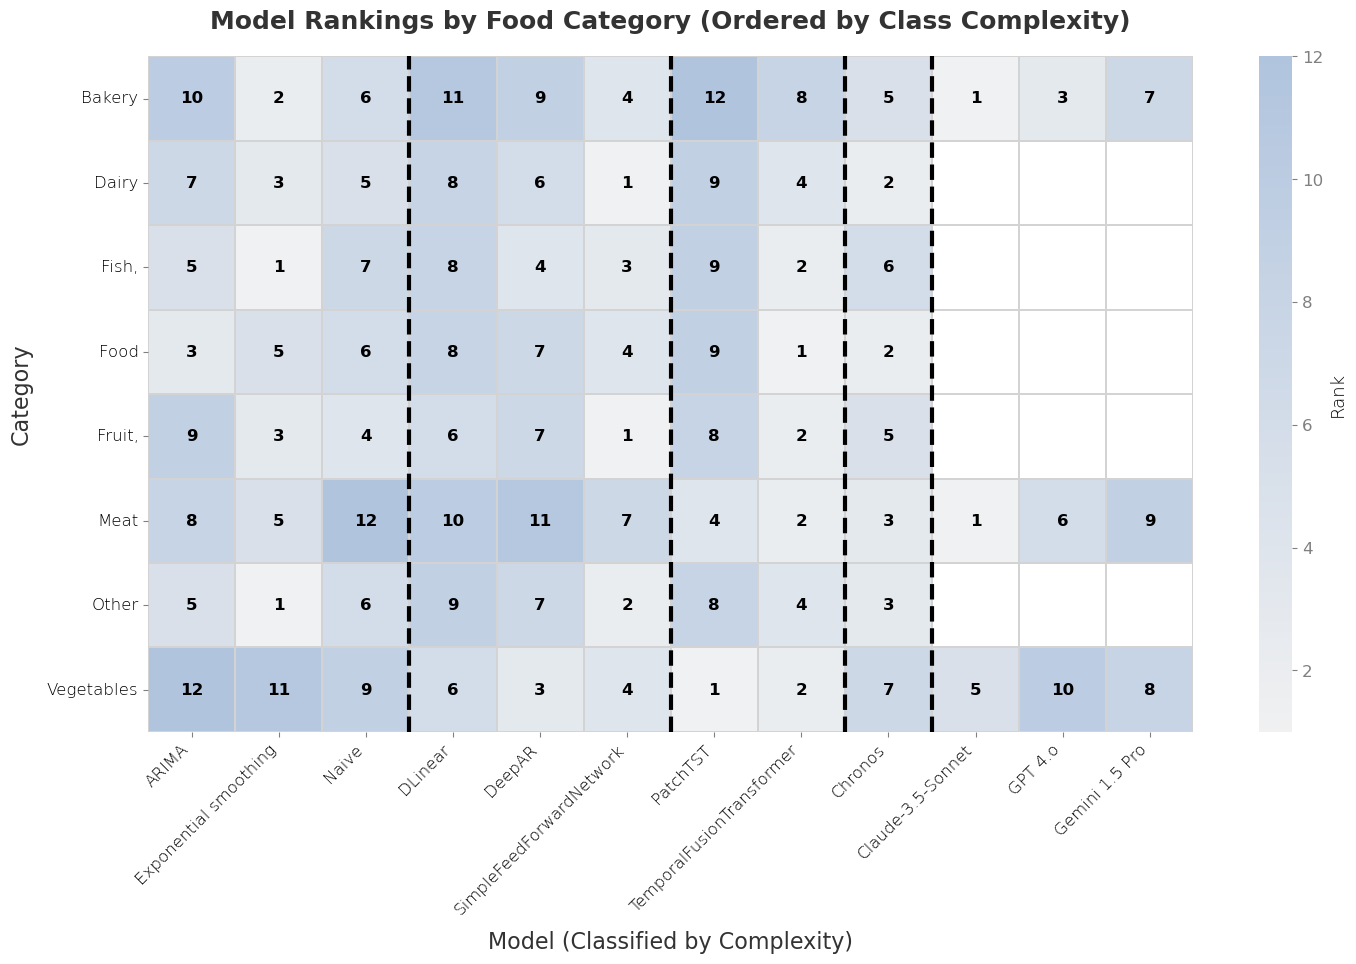

<Figure size 432x288 with 0 Axes>

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming `best_versions` already has the `mape_rank` and 'class' columns
# Step 1: Sort models by their class complexity (least to most complex)
# class_order = best_versions.groupby('model')['model_complexity'].mean().sort_values().index
class_order = best_versions.groupby('model')['model_complexity'].min().sort_values().index

best_versions['model'] = pd.Categorical(best_versions['model'], categories=class_order, ordered=True)

# Step 2: Pivot the table to have categories as rows, models as columns, and mape_rank as values
pivot_df = best_versions.pivot(index='category', columns='model', values='mape_rank')

# Remove "food_cpi" and take the first word of each category for display
pivot_df.index = pivot_df.index.str.replace("food_cpi: ", "").str.split().str[0]

# Sort columns by class order
pivot_df = pivot_df[class_order]

# Set Helvetica as the only font for a clean, modern look
plt.rcParams.update({
    'font.size': 13, 
    'font.family': 'sans-serif',
    'font.sans-serif': ['Helvetica'],
    'axes.edgecolor': 'lightgrey', 
    'axes.linewidth': 0.8,
    'xtick.color': 'gray',
    'ytick.color': 'gray'
})

# Set up the figure with additional padding for a clean look
fig, ax = plt.subplots(figsize=(15, 10), dpi=100)

# Use a light blue color scheme
custom_cmap = sns.light_palette("lightsteelblue", as_cmap=True)

# Plot the heatmap with mape_rank as the visible numbers
sns.heatmap(
    pivot_df, annot=True, cmap=custom_cmap, cbar_kws={'label': 'Rank'}, 
    linewidths=0.2, linecolor='lightgrey', fmt=".0f", annot_kws={"size": 12, "color": "black", "weight": "bold"},
    ax=ax
)

# Calculate class boundaries for separators
model_classes = best_versions.set_index('model')['class'].to_dict()
sorted_classes = [model_classes[model] for model in pivot_df.columns if model in model_classes]
class_boundaries = [i for i in range(1, len(sorted_classes)) if sorted_classes[i] != sorted_classes[i - 1]]

# Add dark green lines between different classes
for boundary in class_boundaries:
    plt.axvline(x=boundary, color='black', linewidth=3, linestyle='--')  # Dark green for class divider

# Customize x and y axis labels
plt.xticks(rotation=45, ha='right', fontsize=12, weight='light', color="black")
plt.yticks(rotation=0, ha='right', fontsize=12, weight='light', color="black")

# Set subtle axis titles with extra padding
plt.title("Model Rankings by Food Category (Ordered by Class Complexity)", fontsize=18, weight='bold', color="#333333", pad=20)
plt.xlabel("Model (Classified by Complexity)", fontsize=16, weight='regular', color="#333333", labelpad=10)
plt.ylabel("Category", fontsize=16, weight='regular', color="#333333", labelpad=10)

# Style the color bar for a sleek appearance
cbar = ax.collections[0].colorbar
cbar.ax.yaxis.label.set_size(13)
cbar.ax.yaxis.label.set_weight("light")
cbar.outline.set_edgecolor('lightgrey')
cbar.ax.tick_params(color='grey', labelsize=12)

# Add layout adjustments for a clean, presentation-ready appearance
plt.tight_layout(pad=2)
plt.show()
plt.rcParams.update({'font.family': 'sans-serif', 'font.sans-serif': ['Helvetica']})

plt.savefig("model_rankings_heatmap.png", format="png", dpi=300, bbox_inches="tight")


In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming `best_versions` already has the `mape_rank` and 'class' columns
# Step 1: Sort models by their class complexity (least to most complex)
# class_order = best_versions.groupby('model')['model_complexity'].mean().sort_values().index
class_order = best_versions.groupby('class')['model_complexity'].min().sort_values().index

best_versions['class'] = pd.Categorical(best_versions['class'], categories=class_order, ordered=True)
best_versions = best_versions.reset_index()

# Step 2: Pivot the table to have categories as rows, models as columns, and mape_rank as values
pivot_df = best_versions.pivot(index='category', columns='class', values='mape_rank')

# Remove "food_cpi" and take the first word of each category for display
pivot_df.index = pivot_df.index.str.replace("food_cpi: ", "").str.split().str[0]

# Sort columns by class order
pivot_df = pivot_df[class_order]

# Set Helvetica as the only font for a clean, modern look
plt.rcParams.update({
    'font.size': 13, 
    'font.family': 'sans-serif',
    'font.sans-serif': ['Helvetica'],
    'axes.edgecolor': 'lightgrey', 
    'axes.linewidth': 0.8,
    'xtick.color': 'gray',
    'ytick.color': 'gray'
})

# Set up the figure with additional padding for a clean look
fig, ax = plt.subplots(figsize=(15, 10), dpi=100)

# Use a light blue color scheme
custom_cmap = sns.light_palette("lightsteelblue", as_cmap=True)

# Plot the heatmap with mape_rank as the visible numbers
sns.heatmap(
    pivot_df, annot=True, cmap=custom_cmap, cbar_kws={'label': 'Rank'}, 
    linewidths=0.2, linecolor='lightgrey', fmt=".0f", annot_kws={"size": 12, "color": "black", "weight": "bold"},
    ax=ax
)

# Calculate class boundaries for separators
model_classes = best_versions.set_index('class')['class'].to_dict()
sorted_classes = [model_classes[model] for model in pivot_df.columns if model in model_classes]
class_boundaries = [i for i in range(1, len(sorted_classes)) if sorted_classes[i] != sorted_classes[i - 1]]

# Add dark green lines between different classes
for boundary in class_boundaries:
    plt.axvline(x=boundary, color='black', linewidth=3, linestyle='--')  # Dark green for class divider

# Customize x and y axis labels
plt.xticks(rotation=45, ha='right', fontsize=12, weight='light', color="black")
plt.yticks(rotation=0, ha='right', fontsize=12, weight='light', color="black")

# Set subtle axis titles with extra padding
plt.title("Model Rankings by Food Category (Ordered by Class Complexity)", fontsize=18, weight='bold', color="#333333", pad=20)
plt.xlabel("Model (Classified by Complexity)", fontsize=16, weight='regular', color="#333333", labelpad=10)
plt.ylabel("Category", fontsize=16, weight='regular', color="#333333", labelpad=10)

# Style the color bar for a sleek appearance
cbar = ax.collections[0].colorbar
cbar.ax.yaxis.label.set_size(13)
cbar.ax.yaxis.label.set_weight("light")
cbar.outline.set_edgecolor('lightgrey')
cbar.ax.tick_params(color='grey', labelsize=12)

# Add layout adjustments for a clean, presentation-ready appearance
plt.tight_layout(pad=2)
plt.show()
plt.rcParams.update({'font.family': 'sans-serif', 'font.sans-serif': ['Helvetica']})

plt.savefig("model_rankings_heatmap.png", format="png", dpi=300, bbox_inches="tight")


ValueError: cannot insert level_0, already exists

In [33]:
# Step 1: Group by `category` and `model_name`, and select the row with the minimum `mean_score` for each group
best_class_df = mape_df.loc[mape_df.groupby(['category', 'class'])['mean_score'].idxmin()]

# Step 2: Sort the resulting DataFrame for readability (optional)
best_class_df = best_class_df.sort_values(by=['category', 'mean_score'])
best_class_df

best_class_df = best_class_df.drop(columns='experiment').reset_index(drop=True)
best_class_df

,index,year,category,mean_score,std_score,scores,path,condition,model_complexity,model,class,rank
0,251,1986,food_cpi: Bakery and cereal products (excludin...,0.028999,0.016868,"[0.02073924951809224, 0.009312911555855808, 0....",f'./output/{exp_test_description}/{EXPERIMENT_...,Exogenous (human),5,Claude-3.5-Sonnet,LLM,1.0
1,51,1986,food_cpi: Bakery and cereal products (excludin...,0.033190,0.029725,"[0.014882080042264502, 0.008929066042039024, 0...",f'./output/{exp_test_description}/{EXPERIMENT_...,Baseline - None,1,Exponential smoothing,Statistical,5.0
2,35,1986,food_cpi: Bakery and cereal products (excludin...,0.035196,0.026723,"[0.00801610596544404, 0.0145599506050403, 0.03...",f'./output/{exp_test_description}/{EXPERIMENT_...,Exogenous (geopolitical),2,SimpleFeedForwardNetwork,Deep Learning,7.0
3,232,1986,food_cpi: Bakery and cereal products (excludin...,0.035216,0.024492,"[0.02530972245710051, 0.01239156869912828, 0.0...",f'./output/{exp_test_description}/{EXPERIMENT_...,Baseline - Exogenous (All),4,Chronos,Foundation,8.0
4,224,1986,food_cpi: Bakery and cereal products (excludin...,0.036700,0.032053,"[0.018710904993841038, 0.017442728735350133, 0...",f'./output/{exp_test_description}/{EXPERIMENT_...,Exogenous (climate),3,TemporalFusionTransformer,Transformer,12.0
5,36,1986,food_cpi: Dairy products and eggs,0.021108,0.015511,"[0.007028814980968349, 0.011423657005791663, 0...",f'./output/{exp_test_description}/{EXPERIMENT_...,Exogenous (geopolitical),2,SimpleFeedForwardNetwork,Deep Learning,1.0
6,131,1986,food_cpi: Dairy products and eggs,0.021389,0.009603,"[0.021225931614835616, 0.011344645235485513, 0...",f'./output/{exp_test_description}/{EXPERIMENT_...,Baseline - None,4,Chronos,Foundation,2.0
7,52,1986,food_cpi: Dairy products and eggs,0.022521,0.015436,"[0.011401594506326239, 0.010328422222780067, 0...",f'./output/{exp_test_description}/{EXPERIMENT_...,Baseline - None,1,Exponential smoothing,Statistical,4.0
8,277,1986,food_cpi: Dairy products and eggs,0.023807,0.014608,"[0.011322252143607603, 0.017907993700903572, 0...",f'./output/{exp_test_description}/{EXPERIMENT_...,Baseline - None,3,TemporalFusionTransformer,Transformer,5.0
9,53,1986,"food_cpi: Fish, seafood and other marine products",0.017427,0.012214,"[0.011707823552438613, 0.008828461062820293, 0...",f'./output/{exp_test_description}/{EXPERIMENT_...,Baseline - None,1,Exponential smoothing,Statistical,1.0


In [34]:
best_versions = best_class_df
# Rank models within each category by `mean_score` from lowest to highest
best_versions['mape_rank'] = best_versions.groupby('category')['mean_score'].rank(method='dense', ascending=True)

# Convert the rank to integer type for cleaner display
best_versions['mape_rank'] = best_versions['mape_rank'].astype(int)

# Display the DataFrame to check the results
best_versions

best_versions = best_versions.sort_values(by='class')

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

KeyError: 'class'

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


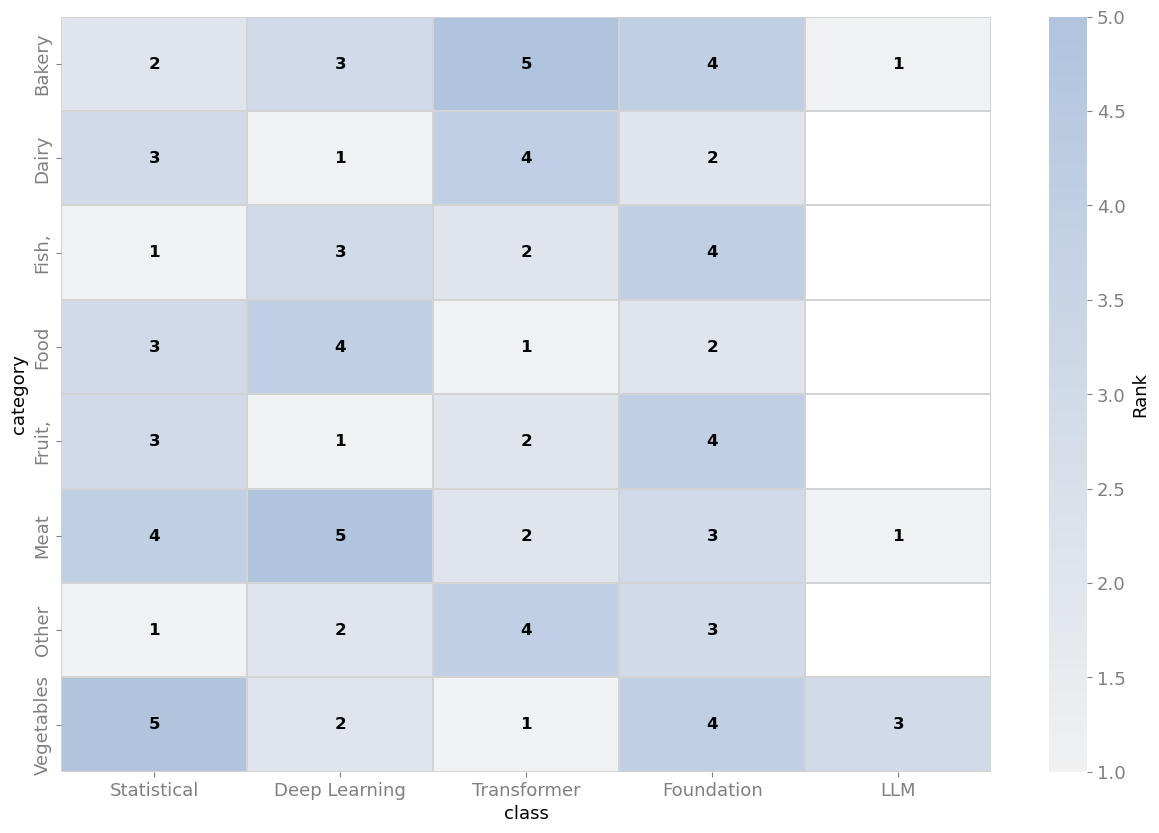

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming `best_versions` already has the `mape_rank` and 'class' columns
# Step 1: Sort models by their class complexity (least to most complex)
# class_order = best_versions.groupby('model')['model_complexity'].mean().sort_values().index
class_order = best_versions.groupby('class')['model_complexity'].min().sort_values().index

best_versions['class'] = pd.Categorical(best_versions['class'], categories=class_order, ordered=True)

# Step 2: Pivot the table to have categories as rows, models as columns, and mape_rank as values
pivot_df = best_versions.pivot(index='category', columns='class', values='mape_rank')

# Remove "food_cpi" and take the first word of each category for display
pivot_df.index = pivot_df.index.str.replace("food_cpi: ", "").str.split().str[0]

# Sort columns by class order
pivot_df = pivot_df[class_order]

# Set Helvetica as the only font for a clean, modern look
plt.rcParams.update({
    'font.size': 13, 
    'font.family': 'sans-serif',
    'font.sans-serif': ['Helvetica'],
    'axes.edgecolor': 'lightgrey', 
    'axes.linewidth': 0.8,
    'xtick.color': 'gray',
    'ytick.color': 'gray'
})

# Set up the figure with additional padding for a clean look
fig, ax = plt.subplots(figsize=(15, 10), dpi=100)

# Use a light blue color scheme
custom_cmap = sns.light_palette("lightsteelblue", as_cmap=True)

# Plot the heatmap with mape_rank as the visible numbers
sns.heatmap(
    pivot_df, annot=True, cmap=custom_cmap, cbar_kws={'label': 'Rank'}, 
    linewidths=0.2, linecolor='lightgrey', fmt=".0f", annot_kws={"size": 12, "color": "black", "weight": "bold"},
    ax=ax
)

# Calculate class boundaries for separators
model_classes = best_versions.set_index('class')['class'].to_dict()
sorted_classes = [model_classes[model] for model in pivot_df.columns if model in model_classes]
class_boundaries = [i for i in range(1, len(sorted_classes)) if sorted_classes[i] != sorted_classes[i - 1]]

# Add dark green lines between different classes
for boundary in class_boundaries:
    plt.axvline(x=boundary, color='black', linewidth=3, linestyle='--')  # Dark green for class divider

# Customize x and y axis labels
plt.xticks(rotation=45, ha='right', fontsize=12, weight='light', color="black")
plt.yticks(rotation=0, ha='right', fontsize=12, weight='light', color="black")

# Set subtle axis titles with extra padding
plt.title("Model Rankings by Food Category (Ordered by Class Complexity)", fontsize=18, weight='bold', color="#333333", pad=20)
plt.xlabel("Model (Classified by Complexity)", fontsize=16, weight='regular', color="#333333", labelpad=10)
plt.ylabel("Category", fontsize=16, weight='regular', color="#333333", labelpad=10)

# Style the color bar for a sleek appearance
cbar = ax.collections[0].colorbar
cbar.ax.yaxis.label.set_size(13)
cbar.ax.yaxis.label.set_weight("light")
cbar.outline.set_edgecolor('lightgrey')
cbar.ax.tick_params(color='grey', labelsize=12)

# Add layout adjustments for a clean, presentation-ready appearance
plt.tight_layout(pad=2)
plt.show()
plt.rcParams.update({'font.family': 'sans-serif', 'font.sans-serif': ['Helvetica']})

plt.savefig("model_rankings_heatmap.png", format="png", dpi=300, bbox_inches="tight")


In [31]:
pivot_df

model,ARIMA,Exponential smoothing,Naive,DLinear,DeepAR,SimpleFeedForwardNetwork,PatchTST,TemporalFusionTransformer,Chronos,Claude-3.5-Sonnet,GPT 4.o,Gemini 1.5 Pro
category,,,,,,,,,,,,
Bakery,10.0,2.0,6.0,11.0,9.0,4.0,12.0,8.0,5.0,1.0,3.0,7.0
Dairy,7.0,3.0,5.0,8.0,6.0,1.0,9.0,4.0,2.0,NaN,NaN,NaN
"Fish,",5.0,1.0,7.0,8.0,4.0,3.0,9.0,2.0,6.0,NaN,NaN,NaN
Food,3.0,5.0,6.0,8.0,7.0,4.0,9.0,1.0,2.0,NaN,NaN,NaN
"Fruit,",9.0,3.0,4.0,6.0,7.0,1.0,8.0,2.0,5.0,NaN,NaN,NaN
Meat,8.0,5.0,12.0,10.0,11.0,7.0,4.0,2.0,3.0,1.0,6.0,9.0
Other,5.0,1.0,6.0,9.0,7.0,2.0,8.0,4.0,3.0,NaN,NaN,NaN
Vegetables,12.0,11.0,9.0,6.0,3.0,4.0,1.0,2.0,7.0,5.0,10.0,8.0
